<a href="https://colab.research.google.com/github/giangdip2410/Research-Stuff/blob/main/CPSC5440_Assigment3_JGM667.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introduction to Autoencoder**

### Library 

In [ ]:
from collections import defaultdict
import copy
import random
import os
import shutil
from urllib.request import urlretrieve
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
from torch.utils.data import Dataset, DataLoader
# from torchvision.transforms.autoaugment import InterpolationMode
import torchvision.models as models
from tqdm import tqdm
from multiprocessing import Pool
cudnn.benchmark = True
from torchsummary import summary
import pickle
import torch.optim as optim
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision
import warnings
from PIL import Image
warnings.filterwarnings('ignore')

### Config

In [ ]:
LEANRING_RATE = 0.001
input_size = (28, 28)
up_scale_ratio = 3
target_size = (28 * up_scale_ratio, 28 * up_scale_ratio)
batch_size = 128
#device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
epochs = 10
#data path
train_path = './data/train/'
test_path =  './data/test1/'
#fix seed
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Data Preporcessing

In [ ]:
#plot image 
def plot_images(images):
    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(20, 15))
    for i in range(rows*cols):
        img = cv2.imread(images[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax = fig.add_subplot(rows, cols, i+1)
        ax.set_title(f"Size of img: {img.shape}")
        ax.imshow(img, cmap='bone')
        ax.axis('off')

In [ ]:
#get image path
train_images_filepaths = [train_path + j for j in os.listdir(train_path)]
#correct image path
train_images_filepaths = [i for i in train_images_filepaths if cv2.imread(i) is not None]
test_images_filepaths = [test_path + j for j in os.listdir(test_path)]
test_images_filepaths = [i for i in test_images_filepaths if cv2.imread(i) is not None]
print("Number of training images: ", len(train_images_filepaths)) 
print("Number of testing images: ",len(test_images_filepaths))
#sample data
sample_plot = train_images_filepaths[:9]

Number of training images:  13270
Number of testing images:  1826


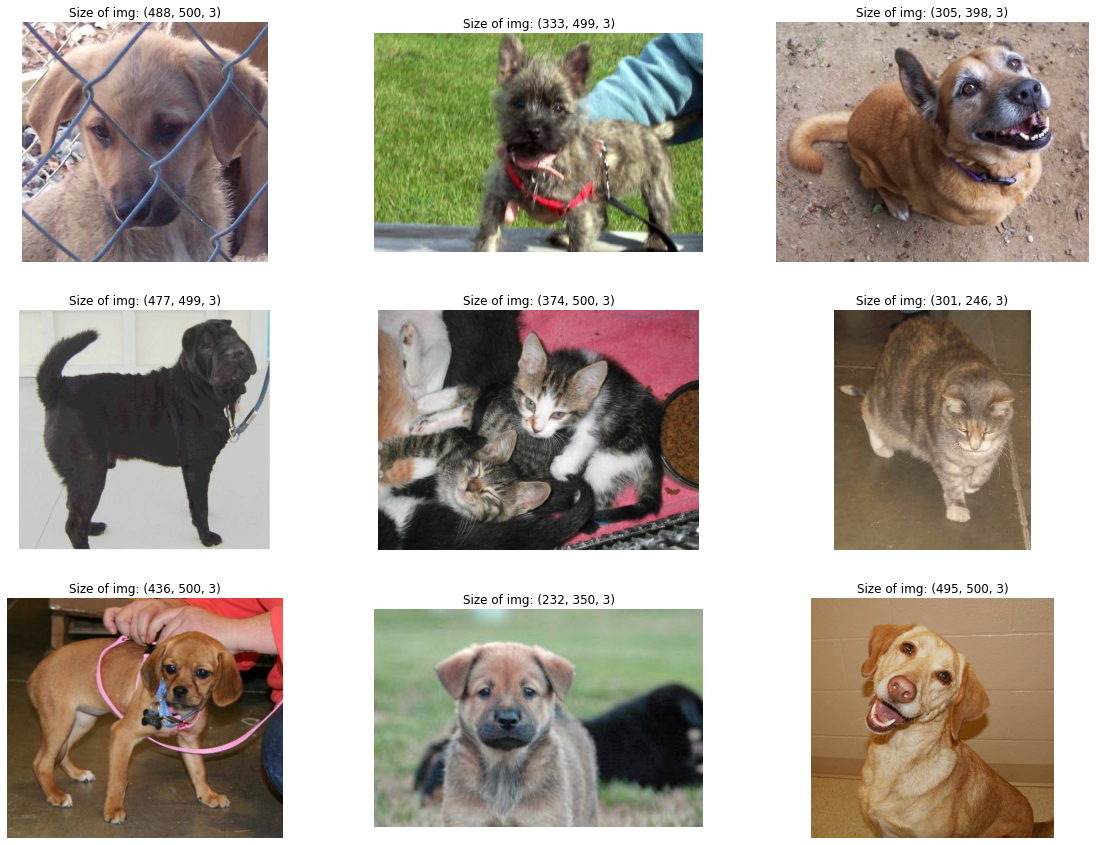

In [ ]:
#plot sample image
plot_images(sample_plot)

### Datasets

In [ ]:
#dataset
class ResolutionDataset(Dataset):
    def __init__(self, images_filepaths, transform=None, target_transform=None):
        self.images_filepaths = images_filepaths
        # self.target_filepaths = target_filepaths
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = Image.open(image_filepath)
        target = Image.open(image_filepath)
        if self.transform is not None:
            image = self.transform(image)
        
        # target images
        if self.target_transform is not None:
            target = self.target_transform(target)
        return image, target

In [ ]:
#data augmentation
train_transform = torchvision.transforms.Compose([
                                        torchvision.transforms.Resize((input_size[0],input_size[1])),
                                        torchvision.transforms.ToTensor()])

val_transform = torchvision.transforms.Compose([
                                        torchvision.transforms.Resize((input_size[0],input_size[1])),
                                        torchvision.transforms.ToTensor()])
target_transform = torchvision.transforms.Compose([
                                        torchvision.transforms.Resize((target_size[0],target_size[1])),
                                        torchvision.transforms.ToTensor()])

In [ ]:
#dataset
train_size = 0.9
train_idx = len(train_images_filepaths) * train_size
train_img_input, val_img_input  = train_images_filepaths[:int(train_idx)], train_images_filepaths[int(train_idx):]
#create dataset
train_dataset = ResolutionDataset(train_img_input, train_transform, target_transform)
valid_dataset = ResolutionDataset(val_img_input,  train_transform, target_transform)
test_dataset = ResolutionDataset(test_images_filepaths,train_transform, target_transform)
#dataloader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Model

In [ ]:
# Define Convolutional AutoEncoder Network
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        #encoder module
        self.encoder = torch.nn.Sequential(
            nn.Upsample(scale_factor=up_scale_ratio, mode='nearest'),
            nn.Conv2d(3, 64, 3, stride=1, padding=1),  
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1),
            nn.Conv2d(64, 16, 3, stride=1, padding=1),  
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  
        )
        #decoder module
        self.decoder = torch.nn.Sequential(
            nn.Upsample(scale_factor=1, mode='nearest'),
            nn.Conv2d(16, 64, 3, stride=1, padding=1),  
            nn.ReLU(True),
            nn.Upsample(scale_factor=1, mode='nearest'),
            nn.Conv2d(64, 3, 3, stride=1, padding=2),  
            nn.Sigmoid()
        )

    def forward(self, x):
        coded = self.encoder(x)
        decoded = self.decoder(coded)
        return decoded

model = AutoEncoder().to(device)
print(model)

AutoEncoder(
  (encoder): Sequential(
    (0): Upsample(scale_factor=3.0, mode=nearest)
    (1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Upsample(scale_factor=1.0, mode=nearest)
    (1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): Upsample(scale_factor=1.0, mode=nearest)
    (4): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (5): Sigmoid()
  )
)


In [ ]:
summary(model, (3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
          Upsample-1            [-1, 3, 84, 84]               0
            Conv2d-2           [-1, 64, 84, 84]           1,792
              ReLU-3           [-1, 64, 84, 84]               0
         MaxPool2d-4           [-1, 64, 83, 83]               0
            Conv2d-5           [-1, 16, 83, 83]           9,232
              ReLU-6           [-1, 16, 83, 83]               0
         MaxPool2d-7           [-1, 16, 82, 82]               0
          Upsample-8           [-1, 16, 82, 82]               0
            Conv2d-9           [-1, 64, 82, 82]           9,280
             ReLU-10           [-1, 64, 82, 82]               0
         Upsample-11           [-1, 64, 82, 82]               0
           Conv2d-12            [-1, 3, 84, 84]           1,731
          Sigmoid-13            [-1, 3, 84, 84]               0
Total params: 22,035
Trainable params: 

### Loss function and Optimization

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr= LEANRING_RATE)

### Training Model

In [ ]:
def train_autoencoder(model,train_dataloader, test_dataloader, epochs):
    # set to training mode
    model.train()

    train_loss_avg = []
    valid_loss_avg = []
    best_loss = 1000
    print('====================== Start Training Autoencoder =====================')
    for epoch in range(epochs):
        train_loss_avg.append(0)
        num_batches = 0
        
        for image_batch, target_batch in tqdm(train_dataloader):
            
            image_batch = image_batch.to(device)
            target_batch = target_batch.to(device)
            # autoencoder reconstruction
            image_batch_recon = model(image_batch)
            
            # reconstruction error
            loss = criterion(image_batch_recon, target_batch)
            
            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            
            # one step of the optmizer (using the gradients from backpropagation)
            optimizer.step()
            
            train_loss_avg[-1] += loss.item()
            num_batches += 1
            
        train_loss_avg[-1] /= num_batches
        print('Epoch [%d / %d] Training Loss: %f' % (epoch+1, epochs, train_loss_avg[-1]))
        # set to evaluation mode
        model.eval()

        test_loss_avg, num_batches = 0, 0
        valid_loss_avg.append(0)
        for image_batch, target_batch in tqdm(test_dataloader):
            
            with torch.no_grad():

                image_batch = image_batch.to(device)
                target_batch = target_batch.to(device)

                # autoencoder reconstruction
                image_batch_recon = model(image_batch)
                # reconstruction error
                loss = criterion(image_batch_recon, target_batch)

                test_loss_avg += loss.item()
                num_batches += 1
        
        test_loss_avg /= num_batches
        valid_loss_avg[-1] = test_loss_avg
        if test_loss_avg < best_loss:
            best_loss = test_loss_avg
            torch.save(model.state_dict(), "conv_autoencoder_best.pt")
        print('Epoch [%d / %d] Valid Loss: %f' % (epoch+1, epochs, test_loss_avg))
    return model, train_loss_avg, valid_loss_avg

In [ ]:
model, train_loss, valid_loss = train_autoencoder(model,train_dataloader, test_dataloader, epochs)

====================== Start Training Autoencoder =====================


100%|██████████| 94/94 [00:59<00:00,  1.57it/s]


Epoch [1 / 10] Training Loss: 0.014334


100%|██████████| 15/15 [00:07<00:00,  1.96it/s]


Epoch [1 / 10] Valid Loss: 0.005057


100%|██████████| 94/94 [00:58<00:00,  1.61it/s]


Epoch [2 / 10] Training Loss: 0.004550


100%|██████████| 15/15 [00:07<00:00,  1.99it/s]


Epoch [2 / 10] Valid Loss: 0.003430


100%|██████████| 94/94 [00:58<00:00,  1.61it/s]


Epoch [3 / 10] Training Loss: 0.003479


100%|██████████| 15/15 [00:07<00:00,  1.98it/s]


Epoch [3 / 10] Valid Loss: 0.003045


100%|██████████| 94/94 [00:58<00:00,  1.61it/s]


Epoch [4 / 10] Training Loss: 0.003192


100%|██████████| 15/15 [00:07<00:00,  1.98it/s]


Epoch [4 / 10] Valid Loss: 0.003064


100%|██████████| 94/94 [00:58<00:00,  1.62it/s]


Epoch [5 / 10] Training Loss: 0.003098


100%|██████████| 15/15 [00:07<00:00,  1.97it/s]


Epoch [5 / 10] Valid Loss: 0.002738


100%|██████████| 94/94 [00:58<00:00,  1.60it/s]


Epoch [6 / 10] Training Loss: 0.003012


100%|██████████| 15/15 [00:07<00:00,  1.98it/s]


Epoch [6 / 10] Valid Loss: 0.002678


100%|██████████| 94/94 [00:58<00:00,  1.61it/s]


Epoch [7 / 10] Training Loss: 0.002970


100%|██████████| 15/15 [00:07<00:00,  1.98it/s]


Epoch [7 / 10] Valid Loss: 0.002603


100%|██████████| 94/94 [00:58<00:00,  1.61it/s]


Epoch [8 / 10] Training Loss: 0.002827


100%|██████████| 15/15 [00:07<00:00,  2.00it/s]


Epoch [8 / 10] Valid Loss: 0.002582


100%|██████████| 94/94 [00:58<00:00,  1.61it/s]


Epoch [9 / 10] Training Loss: 0.002812


100%|██████████| 15/15 [00:07<00:00,  2.00it/s]


Epoch [9 / 10] Valid Loss: 0.002512


100%|██████████| 94/94 [00:58<00:00,  1.61it/s]


Epoch [10 / 10] Training Loss: 0.002783


100%|██████████| 15/15 [00:07<00:00,  1.98it/s]

Epoch [10 / 10] Valid Loss: 0.002834


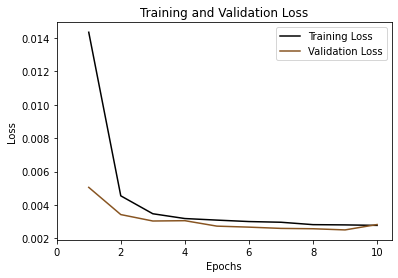

In [ ]:
#plot train plot and valid loss
plt.plot(range(1,epochs+1), train_loss, label='Training Loss', color="#000")
plt.plot(range(1,epochs+1), valid_loss, label='Validation Loss', color="#852")
 
# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(range(0, epochs+1, 2))
 
# Display the plot
plt.legend(loc='best')
plt.show()

### Testing Model

(84, 84, 3)


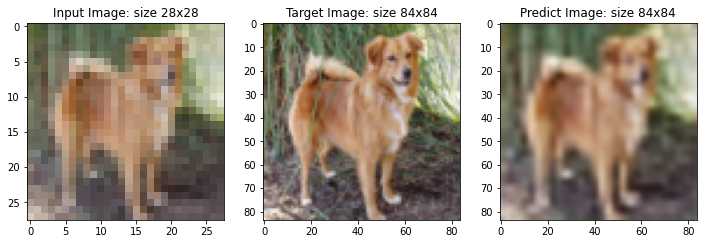

(84, 84, 3)


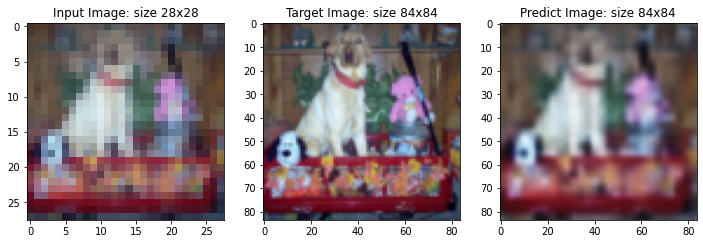

(84, 84, 3)


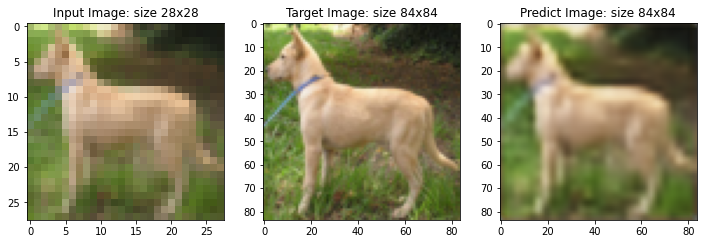

In [ ]:
def convert_img(img):
    """Imshow for Tensor."""
    try:
        img = img.cpu().numpy().transpose((1, 2, 0)) 
    except:
        img = img.cpu().detach().numpy().transpose((1, 2, 0)) 
    return img

#load best model
model.load_state_dict(torch.load('conv_autoencoder_best.pt'))
#save reconstruction images
if not os.path.exists('output_autoencoder'):
    os.mkdir('output_autoencoder')
#plot reconstruction images
list_idx = [7, 19 , 24]
for i in range(len(list_idx)):
    ix = list_idx[i]
    img, target = valid_dataset[ix]
    img_predict = model(img[None].to(device))[0]
    img = convert_img(img)
    target = convert_img(target)
    img_predict = convert_img(img_predict)
    #save output
    print(img_predict.shape)
    Image.fromarray(np.uint8(img_predict*255)).convert('RGB').save(f"output_autoencoder/reconstruction_img_{i}.png")
    fig, ax = plt.subplots(1, 3, figsize=(12,12))
    ax[0].imshow(img)
    ax[0].set_title(f'Input Image: size {img.shape[0]}x{img.shape[0]}')
    ax[1].imshow(target)
    ax[1].set_title(f'Target Image: size {target.shape[0]}x{target.shape[0]}')
    ax[2].imshow(img_predict)
    ax[2].set_title(f'Predict Image: size {img_predict.shape[0]}x{img_predict.shape[0]}')
    plt.show()

### Subjective grading of the quality of output

**With simple Autoencoder moedl (22,035) parameters model can generate very good image at scale (84x84) compare to input image (28x28). If we use more complex Autoencoder model such as using pretrained CNN model as an encoder part, we can improve generating images results**

### Try Another Model: Variational Autoencoder (VAE) 

In [ ]:
# VAE design model
class VAE(nn.Module):
    def __init__(self, z_dim=64, input_c=3):
        super(VAE, self).__init__()

        self.z_dim = z_dim
        #encoder module
        self.encoder = torch.nn.Sequential(
            nn.Upsample(scale_factor=up_scale_ratio, mode='nearest'),
            nn.Conv2d(3, 64, 3, stride=2, padding=1),  
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1),
            nn.Conv2d(64, 16, 3, stride=4, padding=1),  
            nn.ReLU(True),
            nn.Conv2d(16, 16, 3, stride=4, padding=1),  
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  
        )
    
        
        self.mu_fc = nn.Linear(z_dim, z_dim)
        self.logvar_fc = nn.Linear(z_dim, z_dim)

       #decoder module
        self.decoder = torch.nn.Sequential(
            nn.Upsample(scale_factor=84, mode='nearest'),
            nn.Conv2d(64, 16, 3, stride=1),  
            nn.ReLU(True),
            nn.Conv2d(16, 64, 3, stride=1, padding=1),  
            nn.ReLU(True),
            nn.Upsample(scale_factor=1, mode='nearest'),
            nn.Conv2d(64, 3, 3, stride=1, padding=2),  
            nn.Sigmoid()
        )

    def initialize(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        h      = self.encoder(x)
        h = torch.flatten(h, start_dim=1)
        mu     = self.mu_fc(h)                    # mean vector 
        logvar = self.logvar_fc(h)                # logarithm of variance-covariance matrix
        z      = self.reparameterize(mu, logvar)  # latent variable 
        x_hat  = self.decoder(z.view(z.size(0), -1, 1, 1))
        self.mu     = mu.squeeze()
        self.logvar = logvar.squeeze()
        return x_hat

In [ ]:
model2 = VAE().to(device)
summary(model2, (3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
          Upsample-1            [-1, 3, 84, 84]               0
            Conv2d-2           [-1, 64, 42, 42]           1,792
              ReLU-3           [-1, 64, 42, 42]               0
         MaxPool2d-4           [-1, 64, 41, 41]               0
            Conv2d-5           [-1, 16, 11, 11]           9,232
              ReLU-6           [-1, 16, 11, 11]               0
            Conv2d-7             [-1, 16, 3, 3]           2,320
              ReLU-8             [-1, 16, 3, 3]               0
         MaxPool2d-9             [-1, 16, 2, 2]               0
           Linear-10                   [-1, 64]           4,160
           Linear-11                   [-1, 64]           4,160
         Upsample-12           [-1, 64, 84, 84]               0
           Conv2d-13           [-1, 16, 82, 82]           9,232
             ReLU-14           [-1, 16,

In [ ]:
def train_vae(model,train_dataloader, test_dataloader, epochs):
    # set to training mode
    model.train()

    train_loss_avg = []
    valid_loss_avg = []
    best_loss = 1000
    print('====================== Start Training Variational Autoencoder =====================')
    for epoch in range(epochs):
        train_loss_avg.append(0)
        num_batches = 0
        
        for image_batch, target_batch in tqdm(train_dataloader):
            
            image_batch = image_batch.to(device)
            target_batch = target_batch.to(device)
            # autoencoder reconstruction
            image_batch_recon = model(image_batch)
            
            # reconstruction error
            loss = criterion(image_batch_recon, target_batch)
            
            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            
            # one step of the optmizer (using the gradients from backpropagation)
            optimizer.step()
            
            train_loss_avg[-1] += loss.item()
            num_batches += 1
            
        train_loss_avg[-1] /= num_batches
        print('Epoch [%d / %d] Training Loss: %f' % (epoch+1, epochs, train_loss_avg[-1]))
        # set to evaluation mode
        model.eval()

        test_loss_avg, num_batches = 0, 0
        valid_loss_avg.append(0)
        for image_batch, target_batch in tqdm(test_dataloader):
            
            with torch.no_grad():

                image_batch = image_batch.to(device)
                target_batch = target_batch.to(device)

                # autoencoder reconstruction
                image_batch_recon = model(image_batch)
                # reconstruction error
                loss = criterion(image_batch_recon, target_batch)

                test_loss_avg += loss.item()
                num_batches += 1
        
        test_loss_avg /= num_batches
        valid_loss_avg[-1] = test_loss_avg
        if test_loss_avg < best_loss:
            best_loss = test_loss_avg
            torch.save(model.state_dict(), "VAE_best.pt")
        print('Epoch [%d / %d] Valid Loss: %f' % (epoch+1, epochs, test_loss_avg))
    return model, train_loss_avg, valid_loss_avg

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr= LEANRING_RATE)

In [ ]:
model2, train_loss2, valid_loss2 = train_vae(model2,train_dataloader, test_dataloader, epochs)

====================== Start Training Variational Autoencoder =====================


100%|██████████| 94/94 [01:00<00:00,  1.56it/s]


Epoch [1 / 10] Training Loss: 0.062646


100%|██████████| 15/15 [00:07<00:00,  2.03it/s]


Epoch [1 / 10] Valid Loss: 0.064426


100%|██████████| 94/94 [01:00<00:00,  1.56it/s]


Epoch [2 / 10] Training Loss: 0.062700


100%|██████████| 15/15 [00:07<00:00,  2.02it/s]


Epoch [2 / 10] Valid Loss: 0.064400


100%|██████████| 94/94 [00:59<00:00,  1.57it/s]


Epoch [3 / 10] Training Loss: 0.062614


100%|██████████| 15/15 [00:07<00:00,  2.02it/s]


Epoch [3 / 10] Valid Loss: 0.064505


100%|██████████| 94/94 [01:00<00:00,  1.56it/s]


Epoch [4 / 10] Training Loss: 0.062682


100%|██████████| 15/15 [00:07<00:00,  2.00it/s]


Epoch [4 / 10] Valid Loss: 0.064457


100%|██████████| 94/94 [01:00<00:00,  1.55it/s]


Epoch [5 / 10] Training Loss: 0.062549


100%|██████████| 15/15 [00:07<00:00,  2.00it/s]


Epoch [5 / 10] Valid Loss: 0.064379


100%|██████████| 94/94 [01:00<00:00,  1.55it/s]


Epoch [6 / 10] Training Loss: 0.062671


100%|██████████| 15/15 [00:07<00:00,  2.02it/s]


Epoch [6 / 10] Valid Loss: 0.064328


100%|██████████| 94/94 [01:00<00:00,  1.55it/s]


Epoch [7 / 10] Training Loss: 0.062634


100%|██████████| 15/15 [00:07<00:00,  2.00it/s]


Epoch [7 / 10] Valid Loss: 0.064389


100%|██████████| 94/94 [01:00<00:00,  1.55it/s]


Epoch [8 / 10] Training Loss: 0.062643


100%|██████████| 15/15 [00:07<00:00,  2.00it/s]


Epoch [8 / 10] Valid Loss: 0.064393


100%|██████████| 94/94 [01:00<00:00,  1.56it/s]


Epoch [9 / 10] Training Loss: 0.062568


100%|██████████| 15/15 [00:07<00:00,  2.00it/s]


Epoch [9 / 10] Valid Loss: 0.064448


100%|██████████| 94/94 [01:00<00:00,  1.55it/s]


Epoch [10 / 10] Training Loss: 0.062619


100%|██████████| 15/15 [00:07<00:00,  2.01it/s]

Epoch [10 / 10] Valid Loss: 0.064398


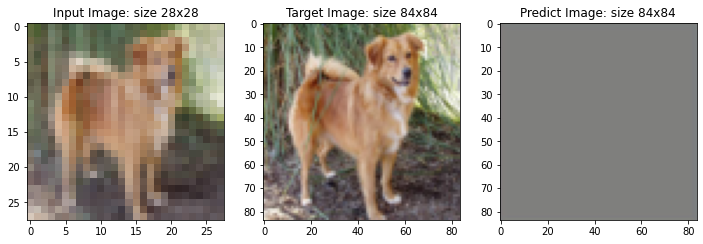

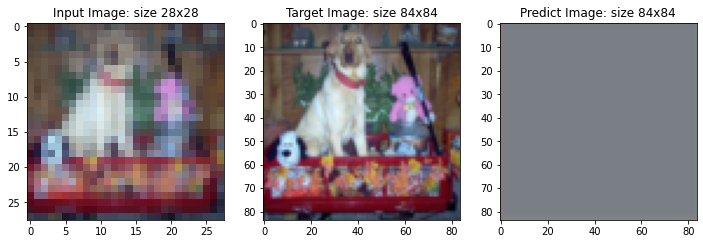

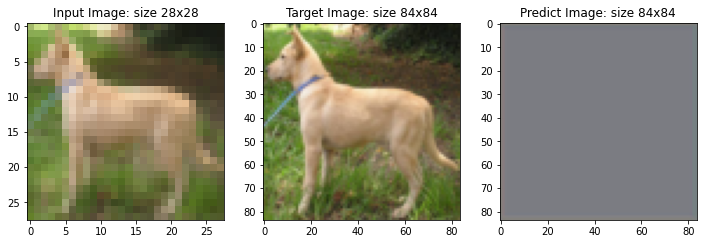

In [ ]:
# Testing with VAE model
#load best model
model2.load_state_dict(torch.load('VAE_best.pt'))
#save reconstruction images
if not os.path.exists('output_VAE'):
    os.mkdir('output_VAE')
#plot reconstruction images
list_idx = [7, 19 , 24]
for i in range(len(list_idx)):
    ix = list_idx[i]
    img, target = valid_dataset[ix]
    img_predict = model2(img[None].to(device))[0]
    img = convert_img(img)
    target = convert_img(target)
    img_predict = convert_img(img_predict)
    #save output
    Image.fromarray(np.uint8(img_predict*255)).convert('RGB').save(f"output_VAE/reconstruction_img_{i}.png")
    fig, ax = plt.subplots(1, 3, figsize=(12,12))
    ax[0].imshow(img)
    ax[0].set_title(f'Input Image: size {img.shape[0]}x{img.shape[0]}')
    ax[1].imshow(target)
    ax[1].set_title(f'Target Image: size {target.shape[0]}x{target.shape[0]}')
    ax[2].imshow(img_predict)
    ax[2].set_title(f'Predict Image: size {img_predict.shape[0]}x{img_predict.shape[0]}')
    plt.show()

### Conclusion

**Variational Autoencoder model with more complex architecture but the generating results are not good as Convolution Autoencoder model.**